In [1]:
#Import Packages
import sys
import pickle
import os
import pytz
import datetime
import string
import re
import pandas as pd
import numpy as np
import calendar
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from windrose import WindroseAxes
import xarray as xr
from pylr2 import regress2
sys.path.append('..')
import funcs.ac_funcs as ac
pd.options.mode.chained_assignment = None
#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
def trim_ds(ds,extent_dict):
    sub_ds =  ds.sel(lat=slice(extent_dict['lat_low'],
                               extent_dict['lat_high']),
                     lon=slice(extent_dict['lon_low'],
                               extent_dict['lon_high']))
    return sub_ds

# Inventories

In [3]:
dataset_extent = {'lon_low':-112.1,
                  'lon_high':-111.7,
                  'lat_low':40.4,
                  'lat_high':41.0} 


## EDGAR

In [47]:
def load_edgar_nc(edgar_path,spec,emi_or_flx,year):
    if spec in ['CH4','CO2']:
        nc_folder_name = f'v8.0_FT2022_GHG_{spec}_{year}_TOTALS_{emi_or_flx}_nc'
        nc_file_name = '_'.join(nc_folder_name.split('_')[:-1]) + '.nc'
    elif spec == 'CO':
        nc_folder_name = f'EDGARv6.1_{spec}_{year}_TOTALS.0.1x0.1'
        nc_file_name = (nc_folder_name) + '.nc'

    nc_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,nc_file_name)
    try:    
        ds = xr.open_dataset(nc_fullpath)
    except FileNotFoundError as f:
        print(f)
        raise FileNotFoundError(f'There doesnt seem to be data for this configuration:{spec},{emi_or_flx},{year}')
    if spec == 'CO':
        ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')
    return ds

<xarray.Dataset>
Dimensions:  (lat: 1800, lon: 3600)
Coordinates:
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.6 ... 179.8 179.9 180.0
Data variables:
    emi_co   (lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    title:             Annual Mean Emissions of CO - 
    institution:       European Commission, Joint Research Centre
    source:            http://edgar.jrc.ec.europa.eu/
    history:           Created from original data (0.1x0.1 degrees) using IDL...
    references:        European Commission, Joint Research Centre (JRC)/Nethe...
    copyright_notice:  Reproduction of the data is authorized, except for com...
    contact:           JRC-EDGAR@ec.europa.eu

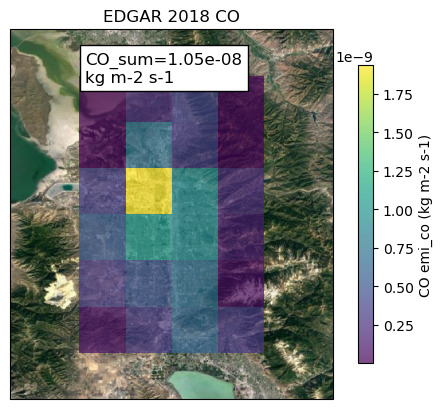

In [48]:
#Load Edgar inventories
edgar_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/EDGAR/'

ch4_co2_ratio = 6.43E-3

spec = 'CO'
year= 2018
emi_or_flx = 'flx'

full_ds = load_edgar_nc(edgar_path,spec,emi_or_flx,year)
sub_ds = trim_ds(full_ds,dataset_extent)
sub_ds_sum = float(sub_ds.sum().to_array().values)

if len(list(sub_ds.keys()))>1:
    raise Exception('Something wrong here, the dataset has more than one variable')
else:
    data_var = list(sub_ds.keys())[0]
    units = sub_ds[list(sub_ds.keys())[0]].attrs['units']

map_extent={'lon_low':-112.25,
            'lon_high':-111.55,
            'lat_low':40.3,
            'lat_high':41.1} 

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))
map = sub_ds[data_var].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
plt.colorbar(map,fraction=0.03,label = f'{spec} {data_var} ({units})')
text = f'{spec}_sum={sub_ds_sum:.2e}\n{units}'
t1 = fig.text(0.45,0.77,text,fontsize = labsize)
t1.set_bbox(dict(facecolor = 'white'))
plt.title(f"EDGAR {year} {spec}")
plt.show()

## Maasakkers EPA

In [10]:
epa_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/Maasakkers'
fname = 'Express_Extension_Gridded_GHGI_Methane_v2_2019.nc'
epa_full = xr.open_dataset(os.path.join(epa_path,fname))
epa_subset = trim_ds(epa_full,dataset_extent).sum(dim="time")
epa_subset_df = epa_subset.to_dataframe()

new_df = pd.DataFrame().reindex_like(epa_subset_df)
new_df = new_df.drop('grid_cell_area',axis = 1)
for col in new_df.columns:
    new_df[col] = epa_subset_df.apply(lambda row: row[col] * row['grid_cell_area'],axis = 1)
summed_df = new_df.sum(axis = 1)
summed_df = summed_df * (1/6.022E23)*16.04E-12*86400*365*1000000
summed_xr = summed_df.to_xarray()

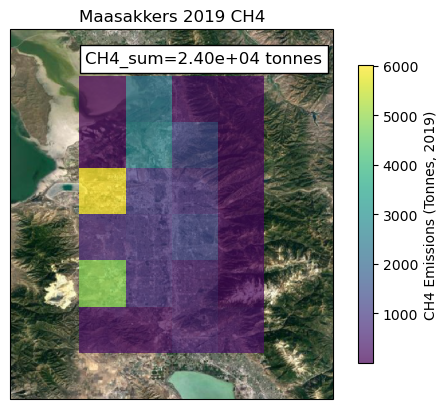

In [11]:
year = 2019
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.axes(projection = proj)
spec = 'CH4'
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))
map = summed_xr.plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
plt.colorbar(map,fraction=0.03,label = f'{spec} Emissions (Tonnes, {year})')

ch4_total = int(summed_xr.sum())
text = f'CH4_sum={ch4_total:.2e} tonnes'
t1 = fig.text(0.45,0.81,text,fontsize = labsize)
t1.set_bbox(dict(facecolor = 'white'))
plt.title("Maasakkers 2019 CH4")
plt.show()

## NOAA CSL

In [ ]:
def get_satsunwkd(year,month):
    '''Gets the number of saturdays, sundays and weekdays in a given month+year
    
    Args:
    year (int) : the year
    month (int) : the month, as an integer
    
    Returns:
    sat_count (int) : number of saturdays
    sun_count (int) : number of sundays
    wkd_count (int) : number of weekdays
    '''

    num_days_in_month = calendar.monthrange(year,month)[1]
    month_str = f'{month:02d}'

    dow_ints = list(pd.date_range(start=f'{year}-{month_str}-01',end=f'{year}-{month_str}-{num_days_in_month}').weekday)
    sat_count = len([ dow for dow in dow_ints if dow == 5 ])
    sun_count = len([ dow for dow in dow_ints if dow == 6 ])
    wkd_count = len([ dow for dow in dow_ints if dow < 5 ])
    return sat_count,sun_count,wkd_count

In [ ]:
csl_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/NOAA_CSL'
year = 2019
month = 1
month_str = f'{month:02d}'

day_type = 'WKD'
full_fname = os.path.join(csl_path,f'{day_type}_nc',f'CO2_{day_type}_{year}_{month_str}_NOAA_CSL_SLV_lon.lat.nc')
csl_xr = xr.open_dataset(full_fname)
csl_xr = trim_ds(csl_xr,dataset_extent)
csl_xr = csl_xr * 3600
csl_xr = csl_xr.sum(dim='hour_UTC')
summed_csl = xr.full_like(csl_xr['CO2_EGU_point'],0)
for data_var in list(csl_xr.data_vars):
    summed_csl = summed_csl + csl_xr[data_var]

summed_csl.mean() #/ 1E6 * 365 * 16 /1E6 * 2259838224


In [ ]:
csl_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/NOAA_CSL'
year = 2019
month = 1
month_str = f'{month:02d}'

day_type = 'WKD'
full_fname = os.path.join(csl_path,f'{day_type}_nc',f'CO2_{day_type}_{year}_{month_str}_NOAA_CSL_SLV_lon.lat.nc')
csl_xr = xr.open_dataset(full_fname)
csl_xr = trim_ds(csl_xr,dataset_extent)
csl_xr = csl_xr * 60 * 60
csl_xr = csl_xr.sum(dim='hour_UTC')
#csl_xr = csl_xr *86400
# summed_csl = xr.full_like(csl_xr['CO2_EGU_point'],0)
# for data_var in list(csl_xr.data_vars):
#     summed_csl = summed_csl + csl_xr[data_var]

# summed_csl.mean() #* 86400 / 1E6 * 365 * 16 /1E6 * 2259838224 #/ 1E6 * 365 * 16 /1E6 * 2259838224

In [ ]:
csl_xr.sum()

In [ ]:
# Load CO2 csl for weekday in jan
co2_wkd_csl = xr.open_dataset('/uufs/chpc.utah.edu/common/home/lin-group10/HKH/CLS_NOAA_Emissions/Emission_Eval/NCDF_Grid_SLV/WKD_nc/CO2_WKD_2019_01_NOAA_CSL_SLV_lon.lat.nc')
co2_wkd_csl = trim_ds(co2_wkd_csl,dataset_extent)
co2_wkd_csl_hour = co2_wkd_csl*3600
co2_csl_timesum = co2_wkd_csl_hour.sum(dim='hour_UTC')
summed_csl_da = xr.full_like(co2_csl_timesum['CO2_EGU_point'],0)
for data_var in list(co2_csl_timesum.data_vars):
    summed_csl_da = summed_csl_da + co2_csl_timesum[data_var]

In [ ]:
co2_csl_timemean = co2_wkd_csl.mean(dim='hour_UTC')
summed_csl_da = xr.full_like(co2_csl_timemean['CO2_EGU_point'],0)
for data_var in list(co2_csl_timemean.data_vars):
    summed_csl_da = summed_csl_da + co2_csl_timemean[data_var]

In [ ]:
summed_csl_da.mean() 

In [ ]:
x = 0
for data_var in list(co2_csl_timemean.data_vars):
    x+= float(co2_csl_timemean[data_var].mean())
x * 86400 / 1E6 * 365 * 16 /1E6 * 2259838224


In [ ]:
x

In [ ]:
summed_csl_da.mean()

In [ ]:
#Plot it
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 9.0 # prob have to adjust this
ax.add_image(request,int(scale))

map = summed_csl_da.plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False,vmax = 2000000)
plt.colorbar(map,fraction=0.03,label ='CO2 Flux umol/s/m2')
plt.show()